# Problem 2: Regression

     dewptc  hum  wndspd  pressure  rain  smoke  temp
0        28   59      20      1008     0      0    20
1        48   61      10      1012     1      0    21
2        24   53       3      1001     0      0    16
3        17   54       8      1002     0      0    16
4        27   51       5      1007     0      0    14
..      ...  ...     ...       ...   ...    ...   ...
995      46   51      14       998     0      1    15
996      40   54      12      1012     0      1    16
997      27   51      13      1021     0      0    15
998      38   48      15      1006     1      1    13
999      38   96      17      1005     1      0    30

[1000 rows x 7 columns]


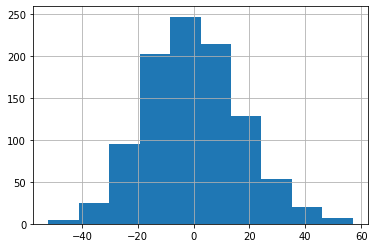

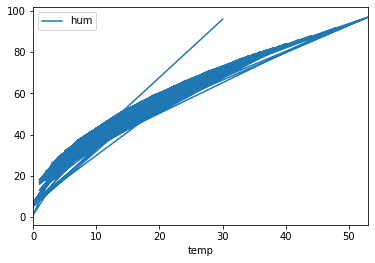

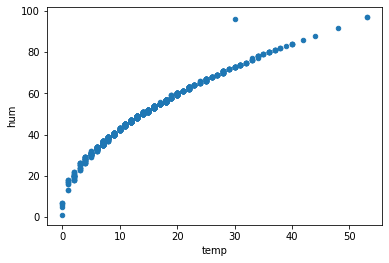

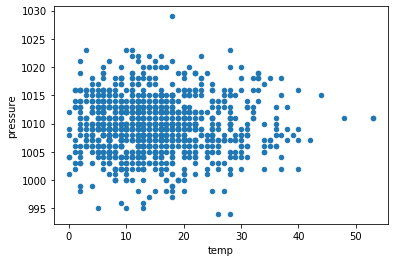

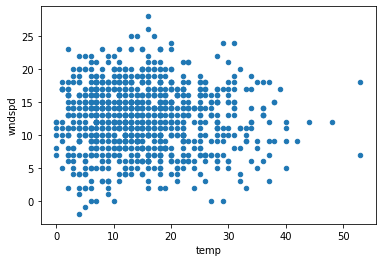

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from math import pi
from math import exp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('weather_data.csv')

#Rearranging columns in the input

cols = df.columns.tolist()

print(df)
df['dewptc'].diff().hist()
df.plot(x='temp',y='hum')
df.plot.scatter(x='temp',y='hum')
df.plot.scatter(x='temp',y='pressure')
df.plot.scatter(x='temp',y='wndspd')

# Data Preparation

## Splitting into Test and Train sets

In [2]:
#Linear Regression

#randomize indices, take the first 80% of the indices and last 20 percent as test
indices = np.random.permutation(df.shape[0])
train_ind, test_ind = indices[:int(0.7*df.shape[0])], indices[int(0.7*df.shape[0]):]
# print(len(train_ind), len(test_ind))

#select the data corresponding to the train and test indices and save into 2 dataframes. Reset index afterwards
train_df, test_df = df.loc[train_ind, :], df.loc[test_ind, :]
train_df, test_df = train_df.reset_index(), test_df.reset_index()

## Data Augmentation and Normalisation

A column of ones is added to represent the "feature" which allows the bias term to be processed with the other coefficients. The columns of non-binary data are normalised by subtracting their mean and dividing by the standard variation of the column. This allows for good convergence and simplifies comparision of results between different methods.

In [3]:
x_train = train_df.iloc[:,1:7]
y_train = train_df.iloc[:,7]

x_test = test_df.iloc[:,1:7]
y_test = test_df.iloc[:,7]

#augmenting data to include constant term
x_train['ones'] = 1
x_test['ones'] = 1

print(x_train.head())
print(y_train.head())

# x_train['dewptc'] = (x_train['dewptc']-x_train['dewptc'].mean())/(x_train['dewptc'].std())
# x_train['hum'] = (x_train['hum']-x_train['hum'].mean())/(x_train['hum'].std())
# x_train['wndspd'] = (x_train['wndspd']-x_train['wndspd'].mean())/(x_train['wndspd'].std())
# x_train['pressure'] = (x_train['pressure']-x_train['pressure'].mean())/(x_train['pressure'].std())
# normalizing columns
for col in ['dewptc', 'hum', 'wndspd', 'pressure']:
    x_train[col] = (x_train[col]-x_train[col].mean())/(x_train[col].std())
    x_test[col] = (x_test[col]-x_test[col].mean())/(x_test[col].std())


   dewptc  hum  wndspd  pressure  rain  smoke  ones
0      40   59      18      1007     0      0     1
1      24   53       3      1001     0      0     1
2      27   45      16      1016     1      1     1
3      18   46      15      1005     0      1     1
4      20   51      17      1010     0      0     1
0    20
1    16
2    11
3    12
4    14
Name: temp, dtype: int64


## Solving Linear Regression Using Linear Algebra (Pseudoinverse Method)

Using the normal equation to find the least squares value of W, given by ((X'X)-1)X'Y where X = feature matrix (train data) Y = output values (train data). Later it is shown that it is indeed equivalent to L2 regression with 0 constant of regularisation

(700, 7)
(7, 700)
(700,)


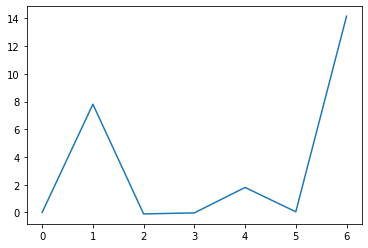

[ 8.58878913e-03  7.80580189e+00 -1.03116442e-01 -2.83387946e-02
  1.80476389e+00  5.00425629e-02  1.41502370e+01]


In [76]:
X = x_train.to_numpy()
print(X.shape)
P_inv_X = np.linalg.pinv(X)
print(P_inv_X.shape)
Y = y_train.to_numpy()
print(Y.shape)

W_pinv = np.matmul(P_inv_X, Y)
plt.plot(W_pinv)
plt.show()
print(W_pinv)

In [77]:
def mseloss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

X_test = x_test.to_numpy()
X_test = np.transpose(X_test)
Y_test = y_test.to_numpy()

y_pred_test = np.matmul(W_pinv.reshape((1, -1)), X_test)
y_pred_train = np.matmul(W_pinv.reshape((1, -1)), X.T)
testerror = mseloss(y_pred_test, Y_test.reshape(1,-1))
trainerror = mseloss(y_pred_train, Y.reshape(1,-1))

print(y_pred_test.shape, y_pred_train.shape)

print('testing mse = {}, training mse = {}'.format(testerror, trainerror))

(1, 300) (1, 700)
testing mse = 4.454529964657118, training mse = 2.645608344885488


# Gradient Descent Methods

In [78]:
X_test = x_test.to_numpy()
X_train = x_train.to_numpy()
Y_test = y_test.to_numpy()
Y_test = Y_test.reshape((Y_test.shape[0],1))
Y_train = y_train.to_numpy()
Y_train = Y_train.reshape((Y_train.shape[0],1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(700, 7)
(300, 7)
(700, 1)
(300, 1)


# Mean Squared Error Loss

### Setting number of iterations and learning rates
Common setting allows direct comparision

In [7]:
num_iter = 200
rate = 0.1
W = np.random.rand(X_train.shape[1],1)

### MSE Loss without Regularisation

[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
2.645882929243378
4.449472042124623


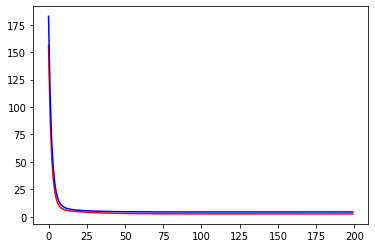

In [8]:
def loss(W,X,Y):
    # W = np.random.rand(7,1)
    square_loss = np.mean((np.matmul(X,W) - Y)**2)
    return square_loss

def gradient(W,X,Y):
    grad = -2*np.matmul(X.T,(np.matmul(X,W) - Y))/X.shape[0]
    return grad

def sgd(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradient(W,X,Y)
        W = W + rate*grad
        train_loss.append(loss(W,X,Y))
        test_loss.append(loss(W,X_test,Y_test))
    return W, train_loss, test_loss

W0 = np.random.rand(X_train.shape[1],1)

W0, train_loss, test_loss = sgd(W0,X_train,Y_train,X_test,Y_test,rate,num_iter)

print(W0)
print(train_loss[-1])
print(test_loss[-1])

plt.plot(train_loss, 'r')
plt.plot(test_loss, 'b')
plt.show()

In [10]:
y_pred_test = np.matmul(W0.reshape((1, -1)), X_test.T)
y_pred_train = np.matmul(W0.reshape((1, -1)), X_train.T)
testerror = mseloss(y_pred_test, Y_test.reshape(1,-1))
trainerror = mseloss(y_pred_train, Y.reshape(1,-1))

print(y_pred_test.shape, y_pred_train.shape)

print('testing mse = {}, training mse = {}'.format(testerror, trainerror))

(1, 300) (1, 700)
testing mse = 4.449472042124623, training mse = 2.645882929243378


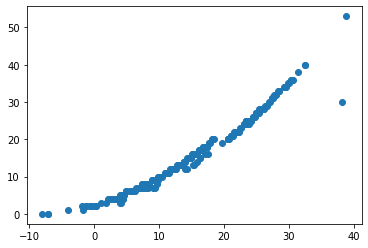

In [11]:
plt.scatter(y_pred_test, Y_test)

/home/harman/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/harman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until


[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
inf
inf


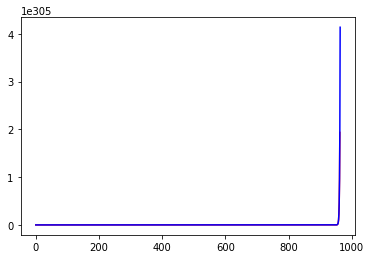

[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
2.645608344885488
4.454529964632954


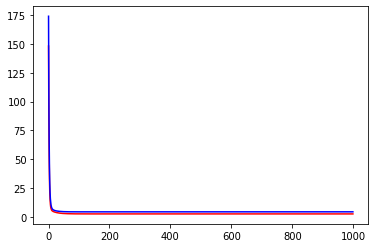

[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
2.6724107403790467
4.43090161393625


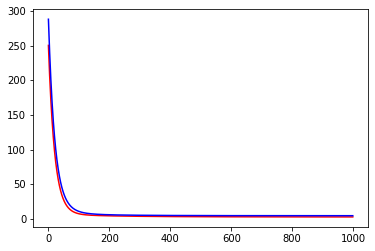

[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
7.717247063936112
10.98711967352263


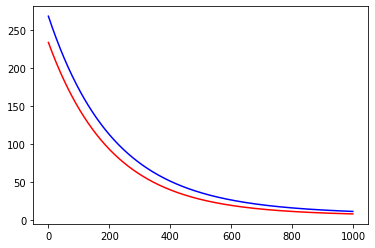

[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
163.21417570023215
191.75791020679796


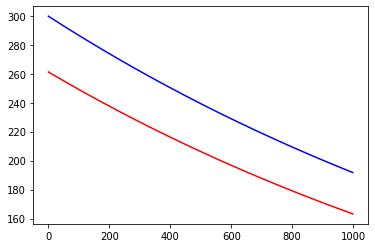

In [12]:
for rate in [1, 0.1, 0.01, 0.001, 0.0001]:
    W = np.random.rand(X_train.shape[1],1)

    W, train_loss, test_loss = sgd(W,X_train,Y_train,X_test,Y_test,rate,1000)

    print(W0)
    print(train_loss[-1])
    print(test_loss[-1])

    plt.plot(train_loss, 'r')
    plt.plot(test_loss, 'b')
    plt.show()

### MSE Loss with L1 Regularisation

[[-0.49501173]
 [ 7.47619325]
 [-0.6409804 ]
 [-0.51400107]
 [ 0.91986613]
 [-1.8465826 ]
 [14.36083432]]
31.006451483590062
34.31172693733076


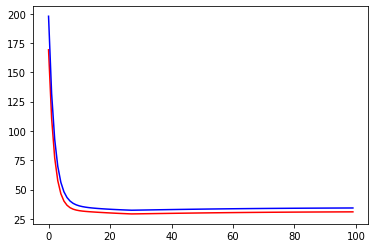

In [13]:
def lossL1(W,X,Y,lam):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) + lam*np.sum(np.abs(W))
    return square_loss

def gradientL1(W,X,Y,lam):
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
    grad = -2*np.matmul(X.T,(np.matmul(X,W)-Y))/X.shape[0] - lam*W_grad
    #print(grad)
    return grad

def sgdL1(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientL1(W,X,Y,lam)
 
        W = W + rate*grad
        train_loss.append(lossL1(W,X,Y,lam))
        test_loss.append(lossL1(W,X_test,Y_test,lam))
    return W, train_loss, test_loss

lam1 = 1

W1 = np.random.rand(X_train.shape[1],1)

W1, train_lossL1, test_lossL1 = sgdL1(W1,X_train,Y_train,X_test,Y_test,0.1,100,lam1)

print(W1)
print(train_lossL1[-1])
print(test_lossL1[-1])

plt.plot(train_lossL1, 'r')
plt.plot(test_lossL1, 'b')
plt.show()

L1 coeff = 10
[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
917.9509222376716
919.203049654633


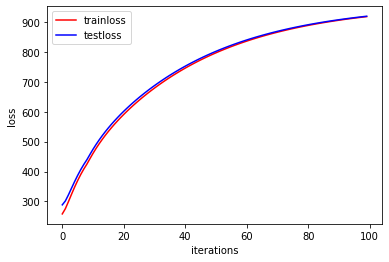

L1 coeff = 1
[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
30.994318121900935
34.29533176173865


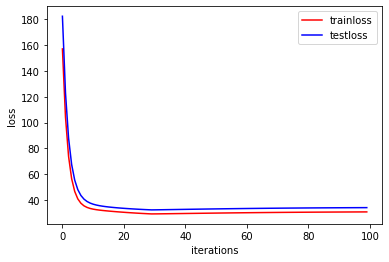

L1 coeff = 0.1
[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
5.0810351384226475
7.011680734319819


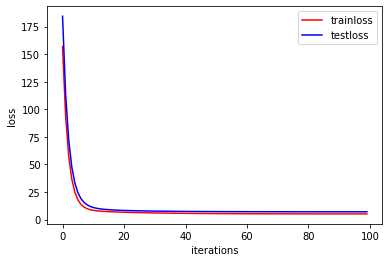

L1 coeff = 0.01
[[ 7.87947034e-03]
 [ 7.79344271e+00]
 [-1.03745984e-01]
 [-2.92380650e-02]
 [ 1.84773842e+00]
 [ 5.69605359e-02]
 [ 1.41339331e+01]]
2.9172089128383076
4.6869537131333265


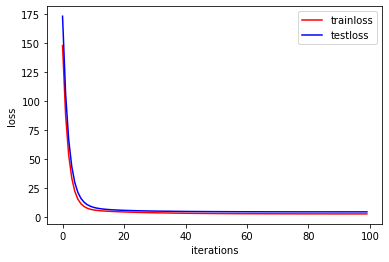

In [14]:
for lam in [10, 1, 0.1, 0.01]:
    print('L1 coeff = {}'.format(lam))
    W = np.random.rand(X_train.shape[1],1)

    W, train_loss, test_loss = sgdL1(W,X_train,Y_train,X_test,Y_test,0.1,100, lam)

    print(W0)
    print(train_loss[-1])
    print(test_loss[-1])

    plt.plot(train_loss, 'r', label = 'trainloss')
    plt.plot(test_loss, 'b', label = 'testloss')
    plt.legend()
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

### MSE Loss with L2 Regularisation

[[-0.01503977]
 [ 6.76813816]
 [-0.10394631]
 [-0.03129397]
 [ 3.29153836]
 [ 1.04170869]
 [12.23754822]]
25.863782064454284
29.69933121385857


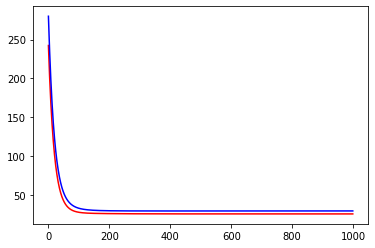

In [15]:
def lossL2(W,X,Y,lam):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) + lam*np.sum(np.multiply(W,W))
    return square_loss

def gradientL2(W,X,Y,lam):
    grad = -2*np.matmul(X.T,(np.matmul(X,W) - Y))/X.shape[0] - 2*lam*W
    return grad

def sgdL2(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientL2(W,X,Y,lam)
    
        W = W + rate*grad
        train_loss.append(lossL2(W,X,Y,lam))
        test_loss.append(lossL2(W,X_test,Y_test,lam))
    return W, train_loss, test_loss

lam2 = 0.1

W2 = np.random.rand(X_train.shape[1],1)

W2, train_lossL2, test_lossL2 = sgdL2(W2,X_train,Y_train,X_test,Y_test,0.01,1000,lam2)

print(W2)
print(train_lossL2[-1])
print(test_lossL2[-1])


plt.plot(train_lossL2, 'r')
plt.plot(test_lossL2, 'b')
plt.show()

### MSE Loss with Elastic Net Regulariser

Using 5 times the number of iterations

[[ 0.01719323]
 [ 6.16718281]
 [-0.01946736]
 [ 0.07127083]
 [ 4.91159248]
 [ 2.23544307]
 [11.05364946]]
27.610438841570865
31.281430181226415


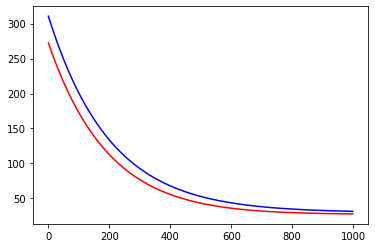

In [16]:
def lossE(W,X,Y,lam1, lam2):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) + lam1*np.sum(np.multiply(W,W)) + lam2*np.sum(np.abs(W))
    return square_loss

def gradientE(W,X,Y,lam1, lam2):
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
    grad = -2*np.matmul(X.T,(np.matmul(X,W) - Y))/X.shape[0] - 2*lam2*W - lam1*W_grad
    return grad

def sgdE(W,X,Y,X_test,Y_test,rate,num_iter,lam1,lam2):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientE(W,X,Y,lam1,lam2)
    
        W = W + rate*grad
        train_loss.append(lossE(W,X,Y,lam1,lam2))
        test_loss.append(lossE(W,X_test,Y_test,lam1,lam2))
    return W, train_loss, test_loss

WE = np.random.rand(X_train.shape[1],1)

lam3 = 0.1
lam4 = 0.01

WE, train_loss_E, test_loss_E = sgdE(WE,X_train,Y_train,X_test,Y_test,0.001,1000,lam3,lam4)

print(WE)
print(train_loss_E[-1])
print(test_loss_E[-1])

plt.plot(train_loss_E, 'r')
plt.plot(test_loss_E, 'b')
plt.show()

## Mean Absolute Error Loss

Using a 100 times lower learning rate for convergence

In [17]:
rate = rate/100

## MAE Loss without regularisation

In [18]:
def loss_mae(W,X,Y):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y))
    return mae_loss

def grad_mae(W,X,Y):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
        
    return np.matmul(X.T,Y_grad)

def sgd_mae(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae(W,X,Y)
        W = W-rate*grad
        train_loss.append(loss_mae(W,X,Y))
        test_loss.append(loss_mae(W,X_test,Y_test))
    
    return W, train_loss, test_loss

[[ 0.02617002]
 [ 7.82516885]
 [-0.03406894]
 [-0.03694511]
 [ 1.40010327]
 [ 0.04898209]
 [13.84073493]]


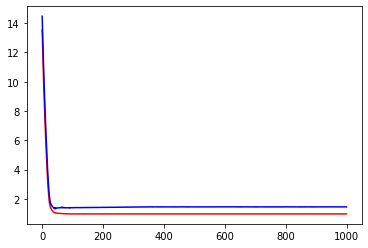

In [19]:
W_mae = np.random.rand(X_train.shape[1],1)

W_mae, train_loss_mae, test_loss_mae = sgd_mae(W_mae,X_train,Y_train,X_test,Y_test,0.001,1000)

print(W_mae)

plt.plot(train_loss_mae,'r')
plt.plot(test_loss_mae,'b')
plt.show()

## Mean Absolute Error with L1 Regularisation

In [20]:
def loss_mae_L1(W,X,Y,lam):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y)) + lam*np.sum(np.abs(W))
    return mae_loss

def grad_mae_L1(W,X,Y,lam):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
            
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
            
    return np.matmul(X.T,Y_grad) + lam*W_grad

def sgd_mae_L1(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae_L1(W,X,Y,lam)
        W = W-rate*grad
        train_loss.append(loss_mae_L1(W,X,Y,lam))
        test_loss.append(loss_mae_L1(W,X_test,Y_test,lam))
    
    return W, train_loss, test_loss

[[ 0.02211519]
 [ 7.82204178]
 [-0.03554638]
 [-0.03356467]
 [ 1.40372375]
 [ 0.044315  ]
 [13.83841063]]


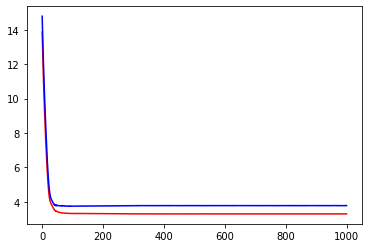

In [21]:
W_mae_L1 = np.random.rand(X_train.shape[1],1)

lam5 = 0.1

W_mae_L1, train_loss_mae_L1, test_loss_mae_L1 = sgd_mae_L1(W_mae_L1,X_train,Y_train,X_test,Y_test,0.001,1000,lam5)

print(W_mae_L1)

plt.plot(train_loss_mae_L1,'r')
plt.plot(test_loss_mae_L1,'b')
plt.show()

## Mean Absolute Error with L2 Regularisation

In [22]:
def loss_mae_L2(W,X,Y,lam):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y)) + lam*np.sum(np.multiply(W,W))
    return mae_loss

def grad_mae_L2(W,X,Y,lam):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
            
    return np.matmul(X.T,Y_grad) + 2*lam*W

def sgd_mae_L2(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae_L2(W,X,Y,lam)
        W = W-rate*grad
        train_loss.append(loss_mae_L2(W,X,Y,lam))
        test_loss.append(loss_mae_L2(W,X_test,Y_test,lam))
    
    return W, train_loss, test_loss

[[ 0.02830944]
 [ 7.81900389]
 [-0.03527988]
 [-0.0345897 ]
 [ 1.55569547]
 [ 0.05364643]
 [13.83521226]]


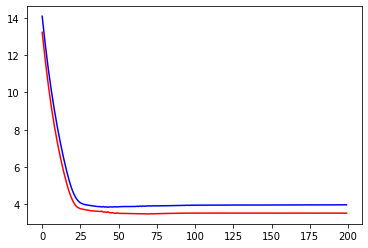

In [23]:
W_mae_L2 = np.random.rand(X_train.shape[1],1)

lam6 = 0.01

W_mae_L2, train_loss_mae_L2, test_loss_mae_L2 = sgd_mae_L2(W_mae_L2,X_train,Y_train,X_test,Y_test,0.001,num_iter,lam6)

print(W_mae_L2)

plt.plot(train_loss_mae_L2,'r')
plt.plot(test_loss_mae_L2,'b')
plt.show()

## Mean Absolute Error with Elastic Net Regularisation

In [24]:
def loss_mae_E(W,X,Y,lam1,lam2):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y)) + lam1*np.sum(np.abs(W)) + lam2*np.sum(np.multiply(W,W))
    return mae_loss

def grad_mae_E(W,X,Y,lam1,lam2):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
            
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
            
    return np.matmul(X.T,Y_grad) + lam1*W_grad + 2*lam2*W

def sgd_mae_E(W,X,Y,X_test,Y_test,rate,num_iter,lam1,lam2):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae_E(W,X,Y,lam1,lam2)
        W = W-rate*grad
        train_loss.append(loss_mae_E(W,X,Y,lam1,lam2))
        test_loss.append(loss_mae_E(W,X_test,Y_test,lam1,lam2))
    
    return W, train_loss, test_loss

[[ 0.01713218]
 [ 7.81886331]
 [-0.03697077]
 [-0.03278266]
 [ 1.54645948]
 [ 0.05006538]
 [13.84399281]]


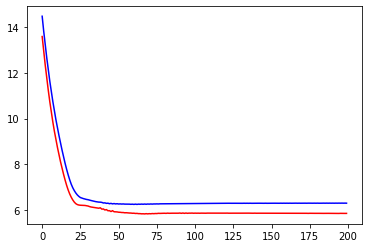

In [25]:
W_mae_E = np.random.rand(X_train.shape[1],1)

lam7 = 0.1
lam8 = 0.01

W_mae_E, train_loss_mae_E, test_loss_mae_E = sgd_mae_E(W_mae_E,X_train,Y_train,X_test,Y_test,0.001,num_iter,lam7,lam8)

print(W_mae_E)

plt.plot(train_loss_mae_E,'r')
plt.plot(test_loss_mae_E,'b')
plt.show()

## Log-cosh Loss

A loss function with several desirable properties. log(cosh(x)) is approximately x^2/2 close to the origin and mod(x) - log(2) away from the origin. Hence it works like MSE, however it is not as sensitive to outliers. It is also twice differentiable everywhere, allowing algorithms to use Newton's method (a second order method) to learn instead of gradient descent techniques. Here the gradient descent implementation is provided.

In [26]:
def loss_logcosh(W,X,Y):
    loss = np.log(np.cosh(np.matmul(X,W) - Y))
    return np.mean(loss)

def grad_logcosh(W,X,Y):
    diff = np.matmul(X,W) - Y
    return np.matmul(X.T,np.tanh(diff))/X.shape[0]

def sgd_logcosh(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_logcosh(W,X,Y)
        W = W - rate*grad
        train_loss.append(loss_logcosh(W,X,Y))
        test_loss.append(loss_logcosh(W,X_test,Y_test))
    return W, train_loss, test_loss

[[ 3.51861234e-02]
 [ 7.81832513e+00]
 [-5.33185116e-02]
 [-1.81982059e-02]
 [ 1.53466733e+00]
 [ 5.81332212e-03]
 [ 1.39545671e+01]]


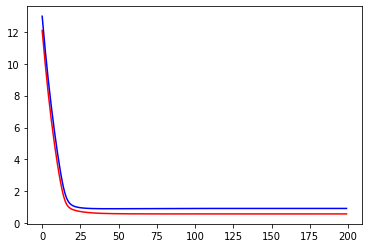

In [27]:
W_logcosh = np.random.rand(X_train.shape[1],1)

W_logcosh, train_loss_lc, test_loss_lc = sgd_logcosh(W_logcosh,X_train,Y_train,X_test,Y_test,1,num_iter)

print(W_logcosh)

plt.plot(train_loss_lc,'r')
plt.plot(test_loss_lc,'b')
plt.show()

## Comparision of the Parameters learnt by each method

## MSE Loss Methods

### Observations:

Push towards sparsity of L1 regularisation can be observed. It also strongly pushes to 0 the parameters which were already close to 0 hence eliminating some features. 

L2 regularisation changes the impacts of each feature trying to improve the quality of each feature. 

These aspects are also seen in Elastic Net Regularisation as it combines both L1 and L2 regularisers. 

The points learnt using the pseudoinverse method overlap with the points learnt without a regulariser hence showing numerically that the normal equation method is identical to no regularisation with square loss.

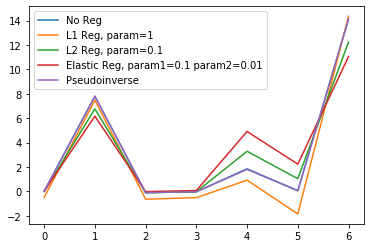

In [74]:
plt.plot(W0, label='No Reg')
plt.plot(W1, label='L1 Reg, param=' + str(lam1))
plt.plot(W2, label='L2 Reg, param=' + str(lam2))
plt.plot(WE, label='Elastic Reg, ' + 'param1=' + str(lam3) + ' param2=' + str(lam4))
plt.plot(W_pinv, label='Pseudoinverse')
plt.legend()
plt.savefig('./Report/plots/weather_MSE_Wplot.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()


## MAE Loss Methods

### Observations


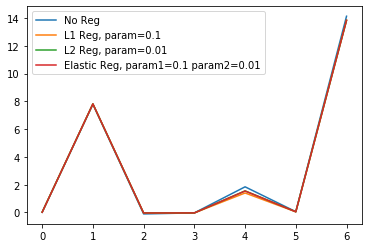

In [75]:
plt.plot(W0, label='No Reg') 
plt.plot(W_mae_L1, label='L1 Reg, param='+ str(lam5))
plt.plot(W_mae_L2,label='L2 Reg, param=' + str(lam6))
plt.plot(W_mae_E, label='Elastic Reg, param1=' + str(lam7) + ' param2=' + str(lam8))
plt.savefig('./Report/plots/weather_MAE_Wplot.jpeg', dpi = 300, bbox_inches = 'tight')
plt.legend()
plt.show()

# NOTE: we donot see overfitting in the above linear plots. 
### Now we will use polynomial regression, overfit the data , validate which degree is correct and then test it

In [32]:
#transforming data into higher degrees
# splitting train into train and validation sets
X_v1d = X_train[0:X_train.shape[0]//5]
X_t1d = X_train[X_train.shape[0]//5:]
X_test1d = X_test
Y_v = Y_train[0:X_train.shape[0]//5]
Y_t = Y_train[X_train.shape[0]//5:]
# Y_test is the same

#2degree x1, x2 ....x1^2, x2^2......
X_v2d = np.concatenate((X_v1d, X_v1d**(2)), axis = 1)
X_t2d = np.concatenate((X_t1d, X_t1d**(2)), axis = 1)
X_test2d = np.concatenate((X_test, X_test*X_test), axis = 1)
#3degree
X_v3d = np.concatenate((X_v2d, X_v1d**(3)), axis = 1)
X_t3d = np.concatenate((X_t2d, X_t1d**(3)), axis = 1)
X_test3d = np.concatenate((X_test2d, X_test**(3)), axis = 1)
#4degree
X_v4d = np.concatenate((X_v3d, X_v1d**(4)), axis = 1)
X_t4d = np.concatenate((X_t3d, X_t1d**(4)), axis = 1)
X_test4d = np.concatenate((X_test3d, X_test**(4)), axis = 1)
#5degree
X_v5d = np.concatenate((X_v4d, X_v1d**(5)), axis = 1)
X_t5d = np.concatenate((X_t4d, X_t1d**(5)), axis = 1)
X_test5d = np.concatenate((X_test4d, X_test**(5)), axis = 1)
#6degree
X_v6d = np.concatenate((X_v5d, X_v1d**(6)), axis = 1)
X_t6d = np.concatenate((X_t5d, X_t1d**(6)), axis = 1)
X_test6d = np.concatenate((X_test5d, X_test**(6)), axis = 1)

X_v7d = np.concatenate((X_v6d, X_v1d**(7)), axis = 1)
X_t7d = np.concatenate((X_t6d, X_t1d**(7)), axis = 1)
X_test6d = np.concatenate((X_test5d, X_test**(6)), axis = 1)

X_v8d = np.concatenate((X_v7d, X_v1d**(8)), axis = 1)
X_t8d = np.concatenate((X_t7d, X_t1d**(8)), axis = 1)
X_test6d = np.concatenate((X_test5d, X_test**(6)), axis = 1)

In [33]:
print(X_v6d.shape, X_t6d.shape, X_test6d.shape)

(140, 42) (560, 42) (300, 42)


In [34]:
def sgdbiasvar(X_train, Y_train, X_test, Y_test, rate, num_iter):
    
    W0 = np.random.rand(X_train.shape[1],1)
    W0, train_loss, test_loss = sgd(W0,X_train,Y_train,X_test,Y_test,rate,num_iter)
    y_pred_test = np.matmul(W0.reshape((1, -1)), X_test.T)
    y_pred_train = np.matmul(W0.reshape((1, -1)), X_train.T)
    testerror = mseloss(y_pred_test, Y_test.reshape(1,-1))
    trainerror = mseloss(y_pred_train, Y_train.reshape(1,-1))

    print(y_pred_test.shape, y_pred_train.shape)

    print('testing mse = {}, training mse = {}'.format(testerror, trainerror))
    plt.scatter(y_pred_test, Y_test)
    x = np.linspace(0,40,100)
    y = x
    plt.plot(x, y, '-r', label='y=x')
    plt.xlabel('Ypredicted', fontsize = 20)
    plt.ylabel('Yactual', fontsize = 20)
    plt.legend()
    return trainerror, testerror, plt

In [65]:
trainbv = []
validbv = []

(1, 140) (1, 560)
testing mse = 3.028141777369976, training mse = 2.5965754149377562
2.5965754149377562 3.028141777369976


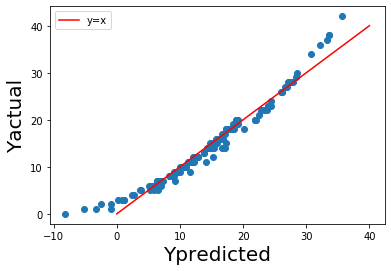

In [66]:
t_error, v_error, plt = sgdbiasvar(X_t1d, Y_t, X_v1d, Y_v, 0.01, 1000)
trainbv.append(t_error)
validbv.append(v_error)
print(t_error, v_error)
# plt.savefig('./Report/plots/weatherpoly_1d.jpeg', dpi = 300, bbox = 'tight')

(1, 140) (1, 560)
testing mse = 0.0831788037325537, training mse = 0.07737677791751142
0.07737677791751142 0.0831788037325537


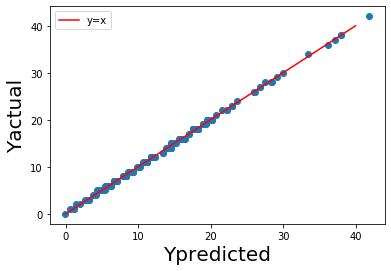

In [67]:
t_error, v_error, plt = sgdbiasvar(X_t2d, Y_t, X_v2d, Y_v, 0.01, 10000)
trainbv.append(t_error)
validbv.append(v_error)
print(t_error, v_error)
# plt.savefig('./Report/plots/weatherpoly_2d', dpi = 300, bbox = 'tight')

(1, 140) (1, 560)
testing mse = 0.08404362464345566, training mse = 0.07965832282247573
0.07965832282247573 0.08404362464345566


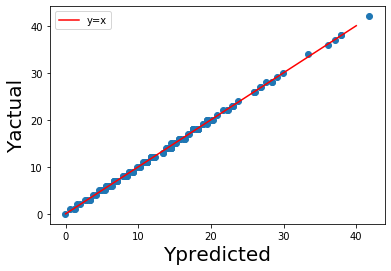

In [68]:
t_error, v_error, plt = sgdbiasvar(X_t3d, Y_t, X_v3d, Y_v, 0.01, 1000)
trainbv.append(t_error)
validbv.append(v_error)
print(t_error, v_error)

(1, 140) (1, 560)
testing mse = 7.682501505916552, training mse = 6.423779964285874
6.423779964285874 7.682501505916552


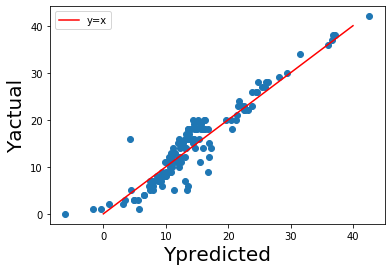

In [69]:
t_error, v_error, plt = sgdbiasvar(X_t4d, Y_t, X_v4d, Y_v, 0.001, 1000)
trainbv.append(t_error)
validbv.append(v_error)
print(t_error, v_error)
# plt.savefig('./Report/plots/weatherpoly_4d', dpi = 300, bbox = 'tight')

(1, 140) (1, 560)
testing mse = 8.738744698347064, training mse = 6.058820305985926
6.058820305985926 8.738744698347064


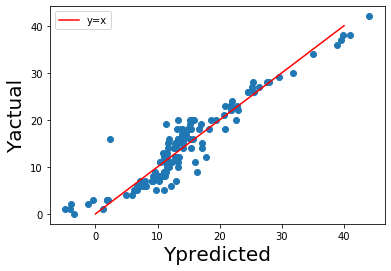

In [70]:
t_error, v_error, plt = sgdbiasvar(X_t5d, Y_t, X_v5d, Y_v, 0.0001, 10000)
trainbv.append(t_error)
validbv.append(v_error)
print(t_error, v_error)

(1, 140) (1, 560)
testing mse = 6.957326347703213, training mse = 5.049583093832078
5.049583093832078 6.957326347703213


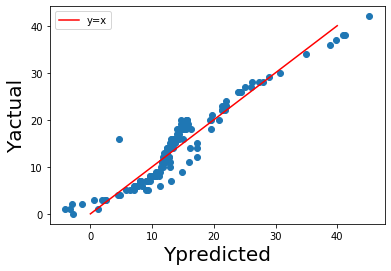

In [71]:
t_error, v_error, plt = sgdbiasvar(X_t6d, Y_t, X_v6d, Y_v, 0.00001, 100000)
trainbv.append(t_error)
validbv.append(v_error)
print(t_error, v_error)
plt.savefig('weatherpoly_6d', dpi = 300, bbox = 'tight')

In [72]:
# t_error, v_error, plt = sgdbiasvar(X_t7d, Y_t, X_v7d, Y_v, 0.000001, 100000)
# trainbv.append(t_error)
# validbv.append(v_error)
# print(t_error, v_error)

## Bias variance plot

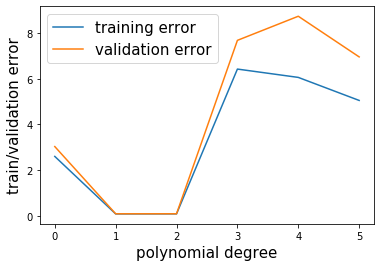

In [73]:
poly = [1, 2, 3, 4 ,5]
plt.plot(trainbv, label = 'training error')
plt.plot(validbv, label = 'validation error')
# plt.xticks(poly)
plt.xlabel('polynomial degree', fontsize = 15)
plt.ylabel('train/validation error', fontsize = 15)
plt.legend(prop={'size': 15})
# plt.savefig('./Report/plots/weather_poly_bias_variance', dpi = 300, bbox = 'tight')
plt.show()

### After the second degree, over fittign start. Also it is to not that the training error also increases 3 rd degree onwards which is due to numerical and overflow errors which causes deviation from theoretical known plots